In [1]:
import pickle
import glob
import sys, copy, os
import time, emcee
import numpy as np
import pyccl as ccl
#sys.path.append('../modules/')
import ModelClusterObservables
sys.path.append('../modules/')
import halo._halo_abundance
import configparser
import flagship_mcmc_config
import matplotlib.pyplot as plt
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
analysis = flagship_mcmc_config.analysis_list[int(0)]
default_config_capish = configparser.ConfigParser()
default_config_capish.read('../config/capish.ini')
default_config_capish['halo_catalogue']['n_mass_bins'] = '200'
default_config_capish['halo_catalogue']['n_redshift_bins'] = '200'
filename = analysis['filename'] 
file = np.load(filename, allow_pickle=True).item()
log10M_data, N_data = file['mean_log10m200b'], file['count_with_m200b_def']

def compute_count_mass(params, count=True, mass=True, recompute_bias=False):

    Om, s8, alpha_lambda, beta_lambda, sigma_lambda = params

    config = copy.deepcopy(default_config_capish)

    config['parameters']['Omega_m'] = str(Om)
    config['parameters']['sigma8'] = str(s8)
    #mass-observable relation
    ##richness (lambda)
    config['parameters']['alpha_lambda'] = str(alpha_lambda)
    config['parameters']['beta_lambda'] = str(beta_lambda)
    config['parameters']['sigma_lambda'] = str(sigma_lambda)

    ClusterAbundanceObject = ModelClusterObservables.UniversePrediction( default_config=config )
    
    params_default = ClusterAbundanceObject.params_default 
    cosmo = params_default['CCL_cosmology']
    params_new = params_default
    compute_new= {'compute_dNdzdlogMdOmega':False,'compute_richness_mass_relation':False, 
                   'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':False,
                 'compute_dNdzdlogMdOmega_log_slope': False}
    adds_new={'add_purity':False, 'add_completeness':False}
    
    skyarea = ClusterAbundanceObject.HaloAbundanceObject.sky_area
    fsky = skyarea/(4*np.pi)

    if count:
        N = ClusterAbundanceObject.model_count(params_new, compute_new, adds_new)
    if recompute_bias:
        Nb = ClusterAbundanceObject.model_bias(params_new, compute_new, adds_new)
        b = Nb/N
    else: b = None
        
    if mass:
        gamma = analysis['Gamma']
        NM_gamma, Nth_m = ClusterAbundanceObject.model_mass(params_new, compute_new, adds_new, 
                                                           gamma=gamma,add_WL_weight = True)
        M = (NM_gamma/Nth_m)**(1/gamma)

    if mass and count==False:
        return ClusterAbundanceObject, np.log10(M)
    if count and mass==False:
        return ClusterAbundanceObject, N, b
    if count and mass:
        return ClusterAbundanceObject, N, b, np.log10(M)
    
        

params_fid = 0.298, 0.8, -9.348, 0.75, 0.3
ClusterAbundanceObject_fid, N_fid, b_fid, log10M_fid = compute_count_mass(params_fid, count=True, mass=True, recompute_bias=True)
params_default = ClusterAbundanceObject_fid.params_default 
cosmo_fid = params_default['CCL_cosmology']
log10M_fid_err = ClusterAbundanceObject_fid.model_error_log10m_one_cluster(10**log10M_fid, cosmo_fid, 
                                                                           Rmin=1, Rmax=5, 
                                                                           ngal_arcmin2=25, shape_noise=0.25, 
                                                                           delta=200, mass_def='mean',
                                                                           sigma_A_prior = 0.03,
                                                                           sigma_c_prior=0.1,
                                                                           cM ='Duffy08')
log10M_fid_err *= 1/np.sqrt(N_fid)
print('==mass==')
print('fid logMass= ',log10M_fid[:,0])
print('data logMass=',log10M_data[:,0])
print('fid logmass_err=', log10M_fid_err[:,0])
print()
print('==count==')
print('fid count= ', N_fid[:,0])
print('data count=', N_data[:,0])

skyarea_fid = ClusterAbundanceObject_fid.HaloAbundanceObject.sky_area
fsky_fid = skyarea_fid/(4*np.pi)

if analysis['SSC_count_covariance']:
    cosmo_fid = ccl.Cosmology( Omega_c = float( default_config_capish['halo_catalogue']['Omega_c_fiducial'] ), 
                               Omega_b = float( default_config_capish['halo_catalogue']['Omega_b_fiducial'] ), 
                               h = float( default_config_capish['halo_catalogue']['h_fiducial'] ), 
                               sigma8 = float( default_config_capish['halo_catalogue']['sigma_8_fiducial'] ), 
                               n_s=float( default_config_capish['halo_catalogue']['n_s_fiducial'] ) )
    SSC = halo._halo_abundance.HaloAbundance()
    Sij = SSC.compute_theoretical_Sij(ClusterAbundanceObject_fid.Z_bin, 
                                      cosmo_fid, fsky_fid, 
                                      S_ij_type = 'full_sky_rescaled_approx', )
    def SSC_cov(Nb, Sij):
        n_rich, n_z = Nb.shape
        Nb_flat = Nb.flatten()[:, np.newaxis]  
        cov_SSC = (Nb_flat * np.kron(np.ones((n_rich, n_rich)), Sij)) * Nb_flat.T
        return cov_SSC
    cov_SSC_fid = SSC_cov(N_fid * b_fid, Sij)

log10M_th_err = log10M_fid_err

def likelihood(params):

    om, s8, alpha, beta, sigma_lambda = params

    if om < 0: return -np.inf
    if om > 1: return -np.inf
    if s8 < 0.5: return -np.inf
    if s8 > 1: return -np.inf
    if sigma_lambda < 0: return -np.inf

    if analysis['summary_stat'] == 'count_only':
        ClusterAbundanceObject, N_th, b_th = compute_count_mass(params, count=True, mass=False)

    if analysis['summary_stat'] == 'mass_only':
        ClusterAbundanceObject, log10M_th = compute_count_mass(params, count=False, mass=True) 
        
    if analysis['summary_stat'] == 'count_mass':
        ClusterAbundanceObject, N_th, b_th, log10M_th = compute_count_mass(params, count=True, mass=True)

    print(N_th)

    ############

    if analysis['summary_stat'] == 'count_only' or analysis['summary_stat'] == 'count_mass':

        if analysis['SSC_count_covariance'] == False: 
            Covariance_count = np.diag( N_th.flatten() )
            
        if analysis['SSC_count_covariance']: 
            Covariance_count = np.diag( N_th.flatten() )
            Covariance_count += cov_SSC_fid

        diff_N = N_data.flatten() - N_th.flatten()
        invC = np.linalg.inv(Covariance_count)
        term1 = np.sum(diff_N.T @ invC @ diff_N)
        sign, logdet = np.linalg.slogdet(Covariance_count)
        ln_likelihood_count = - 0.5 * (term1)# + logdet)

    if analysis['summary_stat'] == 'mass_only' or analysis['summary_stat'] == 'count_mass':
        ln_likelihood_mass = - 0.5*np.sum( ((log10M_data - log10M_th)/log10M_th_err )**2)

    if analysis['summary_stat'] == 'count_only': 
        return ln_likelihood_count
    if analysis['summary_stat'] == 'count_mass': 
        return ln_likelihood_mass + ln_likelihood_count
    if analysis['summary_stat'] == 'mass_only': 
        return ln_likelihood_mass

initial =  params_fid
labels = [r'\Omega_m', r'\sigma_8', r'\alpha', r'\beta', r'\sigma_\lambda']


==mass==
fid logMass=  [14.13969968 14.39235685 14.66217886 14.90031554 15.12035088]
data logMass= [14.14786688 14.39458317 14.67420763 14.89282563 15.09215075]
fid logmass_err= [0.00526339 0.00507397 0.00663449 0.00993582 0.02015923]

==count==
fid count=  [3380.43507557 1559.66785713  385.66052767   84.20884171   11.11416047]
data count= [3717. 1666.  467.  100.   12.]


In [2]:
def proxy_mu_f(logm, z, theta_rm):
    r"""proxy mu"""
    M_min, alpha_lambda, beta_lambda, gamma_lambda, sigma_lambda = theta_rm
    proxy_mu = alpha_lambda + beta_lambda * np.log10(10**logm - M_min) + gamma_lambda * np.log10(1+z)
    return proxy_mu * np.log(10)

In [3]:
nwalker = 150
nstep = 200
ndim = len(initial)
pos = np.array(initial) + .1*np.random.randn(nwalker, ndim)
pos = pos[(pos[:,0] > 0)*(pos[:,0] < 1)*(pos[:,1] > 0.5)*(pos[:,1] < 1)*(pos[:,4] > 0)]


(0.0, 100.0)

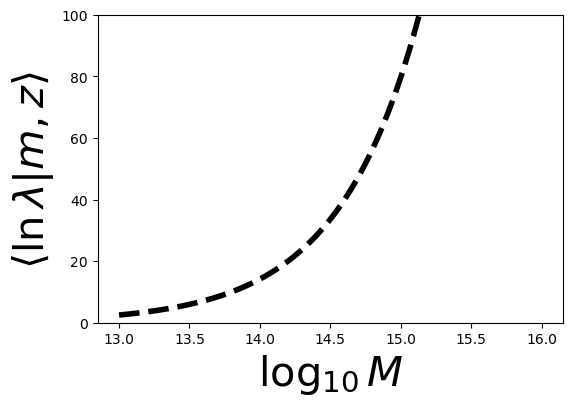

In [28]:
def proxy_mu_f(log10m, z, theta_rm):
    r"""proxy mu"""
    M_min, alpha_lambda, beta_lambda, gamma_lambda, sigma_lambda = theta_rm
    proxy_mu = alpha_lambda + beta_lambda * np.log10(10**log10m - M_min) + gamma_lambda * np.log10(1+z)
    return proxy_mu * np.log(10)


plt.figure(figsize=(6,4))
logm = np.linspace(13, 16, 100)
theta_rm = 134896288259.1656, -9.348, 0.75, 0, 0.3
plt.plot(logm, np.exp(proxy_mu_f(logm, 0.4, theta_rm)), '--k', zorder=100000, lw=4)
plt.ylabel(r'$\langle \ln \lambda|m,z\rangle$', fontsize=30)
plt.xlabel(r'$\log_{10}M$', fontsize=30)
plt.ylim(0, 100)

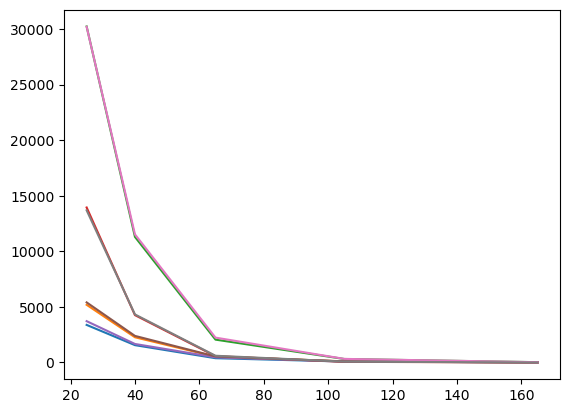

In [26]:
plt.plot(ClusterAbundanceObject_fid.richness_centers,N_fid)
plt.plot(ClusterAbundanceObject_fid.richness_centers,N_data)